In [ ]:
import os
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear

import torch_geometric as tg
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, NNConv, Set2Set
from torch_geometric.nn.aggr import AttentionalAggregation

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import rdkit
from rdkit import Chem
import rdkit.Chem.rdchem as rdc

import matplotlib.pyplot as ax1


In [2]:
import sys
sys.path.append(os.getcwd())

from src.load_utils import *
from src.feature_importance import *

In [ ]:
# Labels/Hyperparameter definition

target_cols = [
    "CONDUCTIVITY",
    "TFSI Diffusivity",
    "Li Diffusivity",
    "Poly Diffusivity",
    "Transference Number",
]

csv_path = 'data/combined_featurized_data.csv'

# Training Parameters
batch_size = 32
num_epochs = 60

# Hidden layer parameters
fea_dim=96
n_layers=4
n_hidden=2

# Adam optimizer hyperparameters
learning_rate = 1e-3
weight_decay =1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
save_dir = "model_out"
os.makedirs(save_dir, exist_ok=True)

In [4]:
# Setup feature ranges based on SMILES strings

def compute_feature_ranges(list_of_smiles):
    atom_symbols = set()
    degrees = set()
    formal_charges = set()
    num_hs = set()
    hybridizations = set()
    
    bond_types = set()
    bond_stereo = set()
    conjugations = set()

    for smile in list_of_smiles:
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            continue
        # mol_atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        for atom in mol.GetAtoms():
            atom_symbols.add(atom.GetSymbol())
            degrees.add(atom.GetDegree())
            formal_charges.add(atom.GetFormalCharge())
            num_hs.add(atom.GetTotalNumHs())
            hybridizations.add(str(atom.GetHybridization()))

        for bond in mol.GetBonds():
            bond_types.add(str(bond.GetBondType()))
            bond_stereo.add(str(bond.GetStereo()))
            conjugations.add(bond.GetIsConjugated())
    
    x_map = {
        "atomic_symbol": sorted(atom_symbols),
        "degree": sorted(degrees),
        "formal_charge": sorted(formal_charges),
        "num_hs": sorted(num_hs),
        "hybridization": sorted(hybridizations),
        "is_aromatic": [False, True],
        "is_in_ring": [False, True],
    }

    e_map = {
        "bond_type": sorted(bond_types),
        "stereo": sorted(bond_stereo),
        "is_conjugated": [False, True],
    }
    return x_map, e_map

def add_unknowns(x_map: dict, e_map: dict):
    # Add UNK token to categorical lists if not present
    for k in ["atomic_symbol", "hybridization"]:
        if "UNK" not in x_map[k]:
            x_map[k].append("UNK")
    # For degree/formal_charge/num_hs: we will keep them as discrete sets but
    # if unseen values appear we will map to a min/max or UNK index — we append 'UNK' as str to be safe.
    for k in ["degree", "formal_charge", "num_hs"]:
        # convert to strings? we keep them as numbers but ensure UNK presence for one_hot implementation
        if "UNK" not in x_map[k]:
            x_map[k] = list(x_map[k]) + ["UNK"]

    for k in ["bond_type", "stereo"]:
        if "UNK" not in e_map[k]:
            e_map[k].append("UNK")

    # ensure boolean lists contain False/True
    x_map['is_aromatic'] = [False, True]
    x_map['is_in_ring'] = [False, True]
    e_map['is_conjugated'] = [False, True]

    return x_map, e_map

def get_bond_feature_dim(e_map):
    dim = (
        len(e_map["bond_type"]) +
        len(e_map["stereo"]) +
        len(e_map["is_conjugated"])
    )
    return dim

In [5]:
# Feature Definition: one-hot, atom (node), bond (edge), generate graph from SMILES

def one_hot(x, choices):
    if x not in choices:
        x = "UNK"
    return np.array([x == c for c in choices], dtype=float)

def atom_features(atom, x_map):
    symbol = atom.GetSymbol()
    degree = atom.GetDegree()
    fc = atom.GetFormalCharge()
    hs = atom.GetTotalNumHs()
    hyb = str(atom.GetHybridization())
    aromatic = atom.GetIsAromatic()
    ring = atom.IsInRing()

    return np.concatenate([
        one_hot(symbol, x_map["atomic_symbol"]),
        one_hot(degree, x_map["degree"]),
        one_hot(fc, x_map["formal_charge"]),
        one_hot(hs, x_map["num_hs"]),
        one_hot(hyb, x_map["hybridization"]),
        one_hot(aromatic, x_map["is_aromatic"]),
        one_hot(ring, x_map["is_in_ring"]),
    ])


def bond_features(bond, e_map):
    btype = str(bond.GetBondType())
    stereo = str(bond.GetStereo())
    conj = bond.GetIsConjugated()

    return np.concatenate([
        one_hot(btype, e_map["bond_type"]),
        one_hot(stereo, e_map["stereo"]),
        one_hot(conj, e_map["is_conjugated"]),
    ])

def smiles_to_graph(smiles, x_map, e_map, add_h: bool = True, add_self_loops=True):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    if add_h:
        mol = Chem.AddHs(mol)
    
    atom_feats = []
    edge_index = []
    edge_feats = []

    # Atom features
    for atom in mol.GetAtoms():
        atom_feats.append(atom_features(atom, x_map))

    # Bond features
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bf = bond_features(bond, e_map)
        edge_index.append([i, j])
        edge_feats.append(bf)

        edge_index.append([j, i])
        edge_feats.append(bf)

    if add_self_loops:
        bond_dim = (
            len(e_map["bond_type"]) +
            len(e_map["stereo"]) +
            len(e_map["is_conjugated"])
        )
        zero_bond = np.zeros(bond_dim, dtype=float)

        num_atoms = len(atom_feats)
        for i in range(num_atoms):
            edge_index.append([i, i])
            edge_feats.append(zero_bond)

    x = torch.tensor(np.array(atom_feats), dtype=torch.float)
    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)
    edge_attr = torch.tensor(np.array(edge_feats), dtype=torch.float)
    
    g = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    g.num_nodes = x.size(0)
    
    return g

In [ ]:
# Process CSV file, generate graphs

class PolymerCSV(InMemoryDataset):
    def __init__(self, csv_path: str, target_cols: list[str], x_map: dict, e_map: dict, add_h: bool = True):
        super().__init__(None)
        self.df = pd.read_csv(csv_path)
        self.target_cols = target_cols

        self.x_map = x_map
        self.e_map = e_map
        self.add_h = add_h

        data_list = []
        for idx, row in self.df.iterrows():
            smi = row.get("Mol_smiles_clean")
            if pd.isna(smi):
                continue
            try:
                g = smiles_to_graph(smi, self.x_map, self.e_map, self.add_h, True)
            except Exception as e:
                print(f"[Warning] Skipping SMILES {smi}: {e}")
                continue

            # collect targets and mask
            y = []
            mask = []
            for c in self.target_cols:
                val = row.get(c, np.nan) # get column value or NaN if unavailable
                if pd.isna(val):
                    y.append(0.0)
                    mask.append(0.0)
                else:
                    y.append(float(val))
                    mask.append(1.0)

            g.y = torch.tensor([y], dtype=torch.float)
            g.y_mask = torch.tensor([mask], dtype=torch.float)
            
            # optional: save trajectory id as meta
            if "Trajectory ID" in row:
                g.traj_id = int(row["Trajectory ID"])
            data_list.append(g)

        self.data, self.slices = self.collate(data_list)


df_no_rescale = read_no_rescale()
mol_cols = [
    c for c in df_no_rescale.columns if c not in [*target_cols, "Mol_smiles_clean", "is_valid", "row_index"]
]
mol_data = torch.tensor(df_no_rescale[mol_cols].values, dtype=torch.float32)

Detecting outliers: 100%|██████████| 64/64 [00:00<00:00, 1569.44it/s]
Checking SMILES validity for column Mol_smiles_clean: 2490it [00:00, 54489.39it/s]


In [ ]:
# Multitask CGCNN setup

class MultiTaskCGCNN(nn.Module):
    def __init__(self, node_in: int, edge_in: int, fea_dim=96, n_layers=4, n_hidden=2, out_dim=5):
        super().__init__()
        self.node_embed = Linear(node_in, fea_dim)
        self.edge_embed = Linear(edge_in, fea_dim)

        self.convs = nn.ModuleList([
            CGConv(channels=fea_dim, dim=fea_dim, aggr="mean", batch_norm=True)
            for _ in range(n_layers)
        ])

        self.pool = AttentionalAggregation(
            gate_nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, 1)),
            nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, fea_dim))
        )

        self.hiddens = nn.ModuleList([Linear(fea_dim + len(mol_cols), fea_dim + len(mol_cols)) for _ in range(n_hidden)])
        self.head = Linear(fea_dim + len(mol_cols), out_dim)

    def forward(self, data: tuple[Data, torch.Tensor]):
        graph_data, mol_data = data
        x = F.leaky_relu(self.node_embed(graph_data.x))
        e = F.leaky_relu(self.edge_embed(graph_data.edge_attr))
        for conv in self.convs:
            x = conv(x, graph_data.edge_index, e)
        g = self.pool(x, graph_data.batch)
        g = torch.cat((g, mol_data), dim=1)
        for h in self.hiddens:
            g = F.leaky_relu(h(g))
        out = self.head(g)
        return out

In [8]:
# Masked MSE & MAE

def masked_mse_loss(pred: torch.Tensor, y: torch.Tensor, mask: torch.Tensor):
    # pred,y,mask -> [B, T]
    
    diff = (pred - y) * mask
    denom = mask.sum()
    if denom.item() == 0:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)
    return (diff * diff).sum() / denom


def masked_mae(pred: np.ndarray, y: np.ndarray, mask: np.ndarray):
    # numpy arrays
    diff = np.abs(pred - y) * mask
    denom = mask.sum()
    if denom == 0:
        return 0.0
    return diff.sum() / denom

In [ ]:
# Train and evaluate epochs

def train_epoch(model, loader, optimizer, scaler: StandardScaler, device):
    model.train()
    total_loss = 0.0
    for batch1, batch2 in loader:
        batch1 = batch1.to(device)
        batch2 = batch2.to(device)
        # scale batch targets (y) using scaler trained on train set
        # scaler expects 2D arrays; convert
        y_cpu = batch1.y.cpu().numpy()
        # IMPORTANT: scaler.transform requires shape [n_samples, n_targets]
        # print(np.shape(y_cpu))
        y_scaled = torch.tensor(scaler.transform(y_cpu), dtype=torch.float, device=device)

        optimizer.zero_grad()
        out = model((batch1, batch2))  # [B, T]
        loss = masked_mse_loss(out, y_scaled, batch1.y_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch1.num_graphs
    
    loss = total_loss / len(loader.dataset)
    return loss


def eval_epoch(model, loader, scaler: StandardScaler, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0

    all_preds = []
    all_preds_scaled = []
    all_ys = []
    all_ys_scaled = []
    all_masks = []

    with torch.no_grad():
        for batch1, batch2 in loader:
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)

            y_cpu = batch1.y.cpu().numpy()
            y_scaled_np = scaler.transform(y_cpu)
            y_scaled = torch.tensor(y_scaled_np, dtype=torch.float, device=device)

            out_scaled = model((batch1, batch2))
            out_scaled_np = out_scaled.numpy

            loss = masked_mse_loss(out_scaled, y_scaled, batch1.y_mask)
            total_loss += loss.item() * batch1.num_graphs

            

            # collect predictions and ground truth in original scale for MAE
            out_unscaled = scaler.inverse_transform(out_scaled.cpu().numpy())
            y_unscaled = batch1.y.cpu().numpy()  # raw y already unscaled

            all_preds.append(out_unscaled)
            all_preds_scaled.append(out_scaled_np)
            all_ys.append(y_unscaled)
            all_ys_scaled.append(y_scaled_np)

            all_masks.append(batch1.y_mask.cpu().numpy())

    if len(all_preds) == 0:
        return total_loss / max(1, len(loader.dataset)), None

    preds = np.vstack(all_preds)
    preds_scaled = np.vstack(all_preds_scaled)
    ys = np.vstack(all_ys)
    ys_scaled = np.vstack(all_ys_scaled)
    masks = np.vstack(all_masks)


    # per task loss/MAE
    T = preds.shape[1]
    per_task_mae = []
    per_task_r2 = []

    for t in range(T):
        mask_t = masks[:, t].astype(bool)

        if mask_t.sum() == 0:
            per_task_mae.append(None)
            per_task_r2.append(None)
            continue

        pred_t = preds_scaled[:, t][mask_t]
        y_t = ys_scaled[:, t][mask_t]

        mae_t = np.mean(np.abs(pred_t - y_t))
        per_task_mae.append(mae_t)

        if len(y_t) > 1:
            per_task_r2.append(r2_score(y_t, pred_t))
        else:
            per_task_r2.append(None)
            
    # compute global loss/MAE across all tasks using masking
    overall_loss = total_loss / len(loader.dataset)
    overall_mae = masked_mae(preds, ys, masks)
    overall_r2 = np.mean(per_task_r2)

    return overall_loss, overall_mae, overall_r2, per_task_mae, per_task_r2

In [10]:
# Create training, validation, testing splits

def create_splits(df: pd.DataFrame, frac_train=0.8, frac_val=0.125):
    n = len(df)
    test_size = 1.0 - frac_train
    idx = np.arange(n)
    train_idx, test_idx = train_test_split(idx, test_size=test_size)
    train_idx, val_idx = train_test_split(train_idx, test_size=frac_val / frac_train)

    return train_idx.tolist(), val_idx.tolist(), test_idx.tolist()

In [11]:
### Build, train, and test model

def model_execution():

    # ============================================================
    # 1) Load CSV + build feature maps
    # ============================================================
    df = read_no_rescale()
    smiles_list = df["Mol_smiles_clean"].dropna().astype(str).tolist()

    print(f"Found {len(smiles_list)} SMILES in CSV.")

    x_map, e_map = compute_feature_ranges(smiles_list)
    x_map, e_map = add_unknowns(x_map, e_map)

    print("\n ===> Atom feature map sizes <===")
    for k, v in x_map.items():
        print(f"{k:>15}: {len(v)}")

    print("\n ===> Edge feature map sizes <===")
    for k, v in e_map.items():
        print(f"{k:>15}: {len(v)}")

    # ============================================================
    # 2) Train/val/test splits
    # ============================================================
    train_idx, val_idx, test_idx = create_splits(df, frac_train=0.8, frac_val=0.1)
    print(f"\nSplit sizes: train={len(train_idx)} val={len(val_idx)} test={len(test_idx)}")

    dataset = PolymerCSV(csv_path, target_cols, x_map=x_map, e_map=e_map, add_h=True)
    print("\nTotal graphs built:", len(dataset))

    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds   = torch.utils.data.Subset(dataset, val_idx)
    test_ds  = torch.utils.data.Subset(dataset, test_idx)
    
    train_mol_ds = torch.utils.data.Subset(mol_data, train_idx)
    val_mol_ds   = torch.utils.data.Subset(mol_data, val_idx)
    test_mol_ds  = torch.utils.data.Subset(mol_data, test_idx)

    train_loader = DataLoader([(d, v) for d, v in zip(train_ds, train_mol_ds)], batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader([(d, v) for d, v in zip(val_ds, val_mol_ds)],     batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader([(d, v) for d, v in zip(test_ds, test_mol_ds)],   batch_size=batch_size, shuffle=False)

    # ============================================================
    # 3) Fit scaler only on training targets
    # ============================================================
    def collect_targets(subset):
        for g in subset:
            print(g, type(g))
            break
        Ys = [g.y.numpy() for g in subset]
        return np.vstack(Ys) if Ys else np.zeros((0, len(target_cols)))

    y_train = collect_targets(train_ds)
    if y_train.shape[0] == 0:
        raise RuntimeError("No training examples with targets found!")

    scaler = StandardScaler()
    scaler.fit(y_train)

    # ============================================================
    # 4) Build model + optimizer
    # ============================================================
    sample = dataset[0]
    node_in = sample.x.shape[1]
    edge_in = sample.edge_attr.shape[1]
    out_dim = len(target_cols)

    model = MultiTaskCGCNN(
        node_in=node_in,
        edge_in=edge_in,
        fea_dim=96,
        n_layers=4,
        n_hidden=2,
        out_dim=out_dim,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

    best_val = float("inf")
    best_path = os.path.join(save_dir, "best_model.pth")

    # ============================================================
    # 5) Unified metrics structure
    # ============================================================
    metrics = {
        "train": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "val": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "test": {
            "loss": None,
            "mae":  None,
            "r2":   None,
            "per_task_mae": {t: None for t in target_cols},
            "per_task_r2":  {t: None for t in target_cols},
        }
    }

    # ============================================================
    # 6) Training loop
    # ============================================================
    for epoch in tqdm(range(1, num_epochs + 1)):

        # ---- training ----
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        tr_loss, tr_mae, tr_r2, tr_pt_mae, tr_pt_r2 = eval_epoch(
            model, train_loader, scaler, device
        )
        tr_loss = train_loss   # override with actual loss from train_epoch

        # ---- validation ----
        val_loss, val_mae, val_r2, val_pt_mae, val_pt_r2 = eval_epoch(
            model, val_loader, scaler, device
        )

        # ---- store metrics ----
        metrics["train"]["loss"].append(tr_loss)
        metrics["train"]["mae"].append(tr_mae)
        metrics["train"]["r2"].append(tr_r2)

        metrics["val"]["loss"].append(val_loss)
        metrics["val"]["mae"].append(val_mae)
        metrics["val"]["r2"].append(val_r2)

        for i, t in enumerate(target_cols):
            metrics["train"]["per_task_mae"][t].append(tr_pt_mae[i])
            metrics["train"]["per_task_r2"][t].append(tr_pt_r2[i])
            metrics["val"]["per_task_mae"][t].append(val_pt_mae[i])
            metrics["val"]["per_task_r2"][t].append(val_pt_r2[i])

        # ---- checkpoint ----
        if val_loss < best_val:
            best_val = val_loss
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "scaler": scaler,
                    "x_map": x_map,
                    "e_map": e_map,
                    "metrics": metrics,
                },
                best_path,
            )

    # ============================================================
    # 7) Final test evaluation
    # ============================================================
    ckpt = torch.load(best_path, map_location=device, weights_only=False)

    model.load_state_dict(ckpt["model_state"])
    scaler = ckpt["scaler"]

    test_loss, test_mae, test_r2, test_pt_mae, test_pt_r2 = eval_epoch(
        model, test_loader, scaler, device
    )

    metrics["test"]["loss"] = test_loss
    metrics["test"]["mae"]  = test_mae
    metrics["test"]["r2"]   = test_r2
    for i, t in enumerate(target_cols):
        metrics["test"]["per_task_mae"][t] = test_pt_mae[i]
        metrics["test"]["per_task_r2"][t]  = test_pt_r2[i]

    return model, metrics


In [17]:
# Plot metrics for final model

def plot_all_metrics(metrics, target_cols, num_epochs):
    epochs = np.arange(1, num_epochs + 1)


    fig_global, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,6))
    # axes = axes.flatten()
    # ============================================================
    # 1. GLOBAL LOSS
    # ============================================================
    ax1.grid(True)
    ax1.plot(epochs, metrics["train"]["loss"], label="Train Loss")
    ax1.plot(epochs, metrics["val"]["loss"],   label="Val Loss")
    ax1.scatter([num_epochs], [metrics["test"]["loss"]], color="red", label="Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Scaled MSE Loss")
    ax1.set_title("Global Loss")
    ax1.legend()

    # ============================================================
    # 2. GLOBAL MAE
    # ============================================================
    ax2.grid(True)
    ax2.plot(epochs, metrics["train"]["mae"], label="Train MAE")
    ax2.plot(epochs, metrics["val"]["mae"],   label="Val MAE")
    ax2.scatter([num_epochs], [metrics["test"]["mae"]], color="red", label="Test MAE")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("MAE")
    ax2.set_title("Global MAE")
    ax2.legend()

    # ============================================================
    # 3. GLOBAL R2
    # ============================================================
    ax3.grid(True)
    ax3.plot(epochs, metrics["train"]["r2"], label="Train R²")
    ax3.plot(epochs, metrics["val"]["r2"],   label="Val R²")
    ax3.scatter([num_epochs], [metrics["test"]["r2"]], color="red", label="Test R²")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("R² Score")
    ax3.set_title("Global R²")
    ax3.legend()

    fig_global.tight_layout()
    plt.show()

    # ============================================================
    # 4. PER-TASK MAE SUBPLOTS
    # ============================================================
    T = len(target_cols)
    ncols = math.ceil(math.sqrt(T))
    nrows = math.ceil(T / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        train_vals = metrics["train"]["per_task_mae"][t]
        val_vals   = metrics["val"]["per_task_mae"][t]
        test_val   = metrics["test"]["per_task_mae"][t]

        ax.plot(epochs, train_vals, label="Train", linewidth=2)
        ax.plot(epochs, val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([num_epochs], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — MAE")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("MAE")
        ax.grid(True)
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task MAE Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # ============================================================
    # 5. PER-TASK R2 SUBPLOTS
    # ============================================================
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        ax.grid(True)

        train_vals = metrics["train"]["per_task_r2"][t]
        val_vals   = metrics["val"]["per_task_r2"][t]
        test_val   = metrics["test"]["per_task_r2"][t]

        ax.plot(epochs, train_vals, label="Train", linewidth=2)
        ax.plot(epochs, val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([num_epochs], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — R²")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("R²")
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task R² Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


Detecting outliers: 100%|██████████| 64/64 [00:00<00:00, 1976.25it/s]
Checking SMILES validity for column Mol_smiles_clean: 2490it [00:00, 56959.23it/s]


Found 2490 SMILES in CSV.

 ===> Atom feature map sizes <===
  atomic_symbol: 8
         degree: 5
  formal_charge: 2
         num_hs: 5
  hybridization: 4
    is_aromatic: 2
     is_in_ring: 2

 ===> Edge feature map sizes <===
      bond_type: 4
         stereo: 2
  is_conjugated: 2

Split sizes: train=1743 val=249 test=498

Total graphs built: 6270
Data(x=[32, 28], edge_index=[2, 94], edge_attr=[94, 8], y=[1, 5], y_mask=[1, 5], num_nodes=32) <class 'torch_geometric.data.data.Data'>


100%|██████████| 60/60 [00:18<00:00,  3.28it/s]


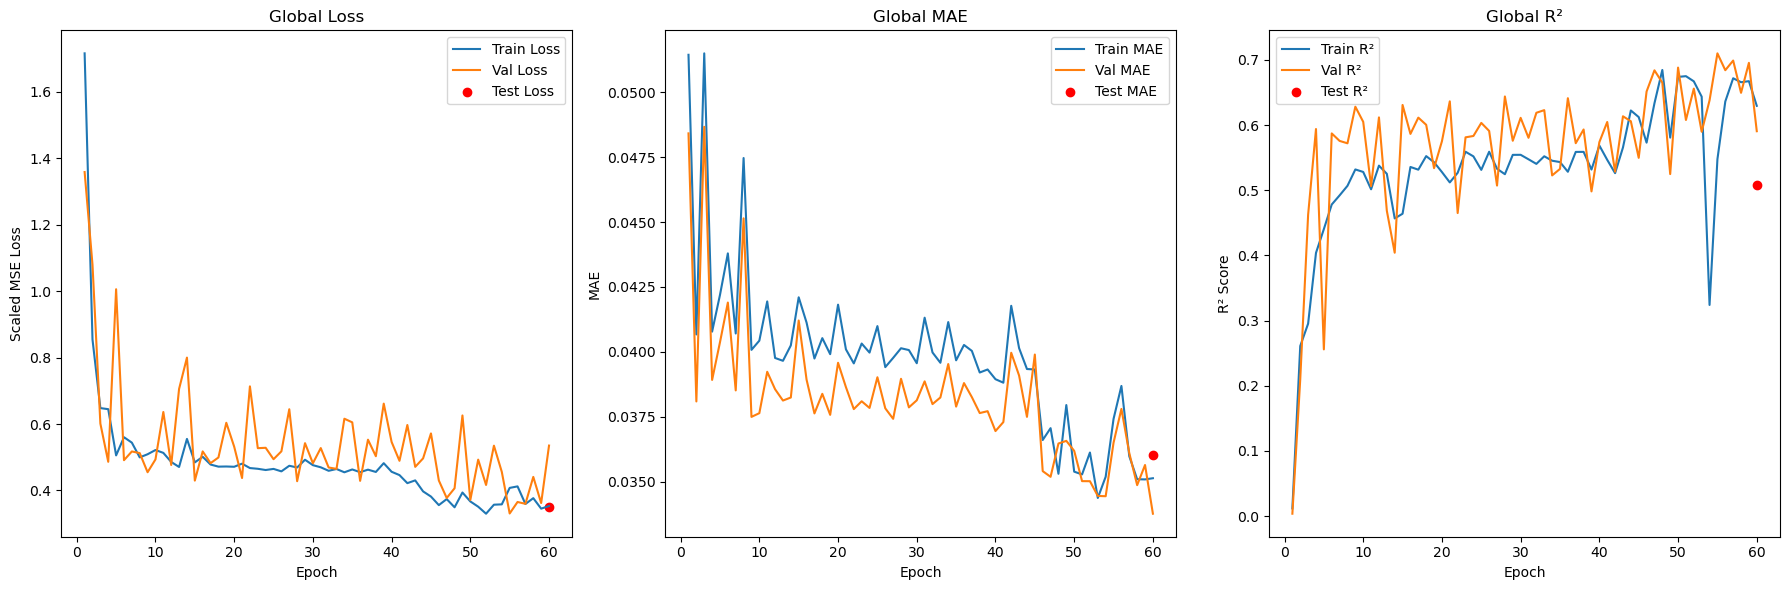

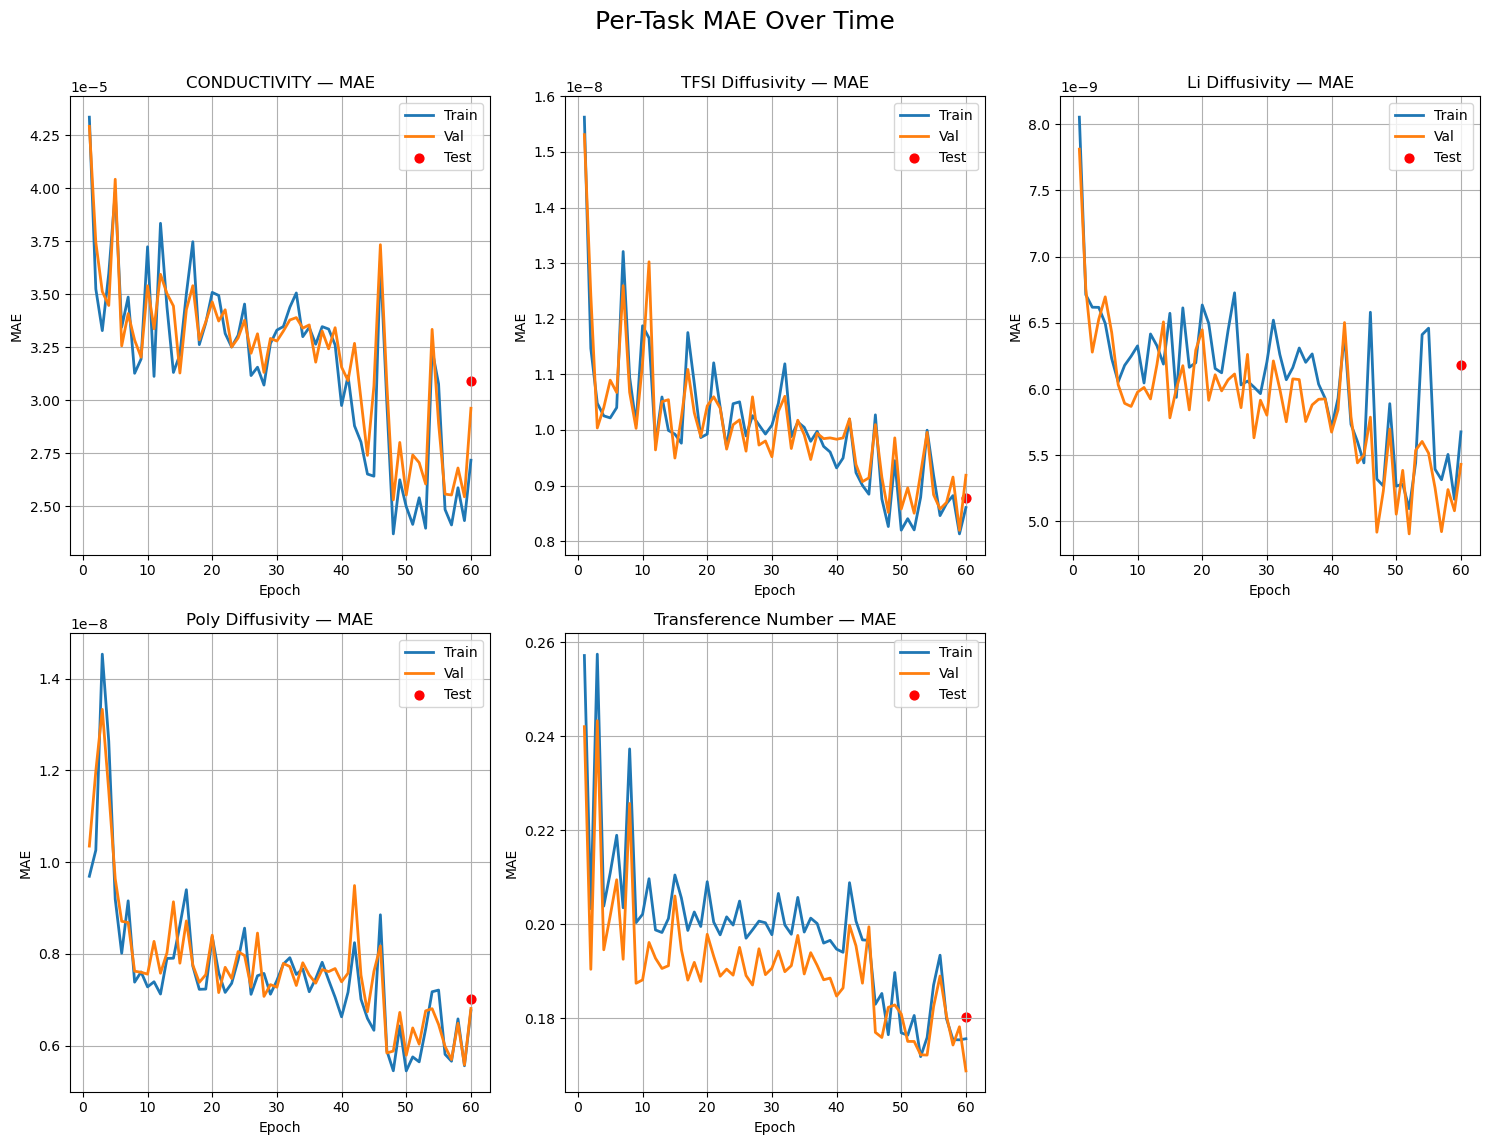

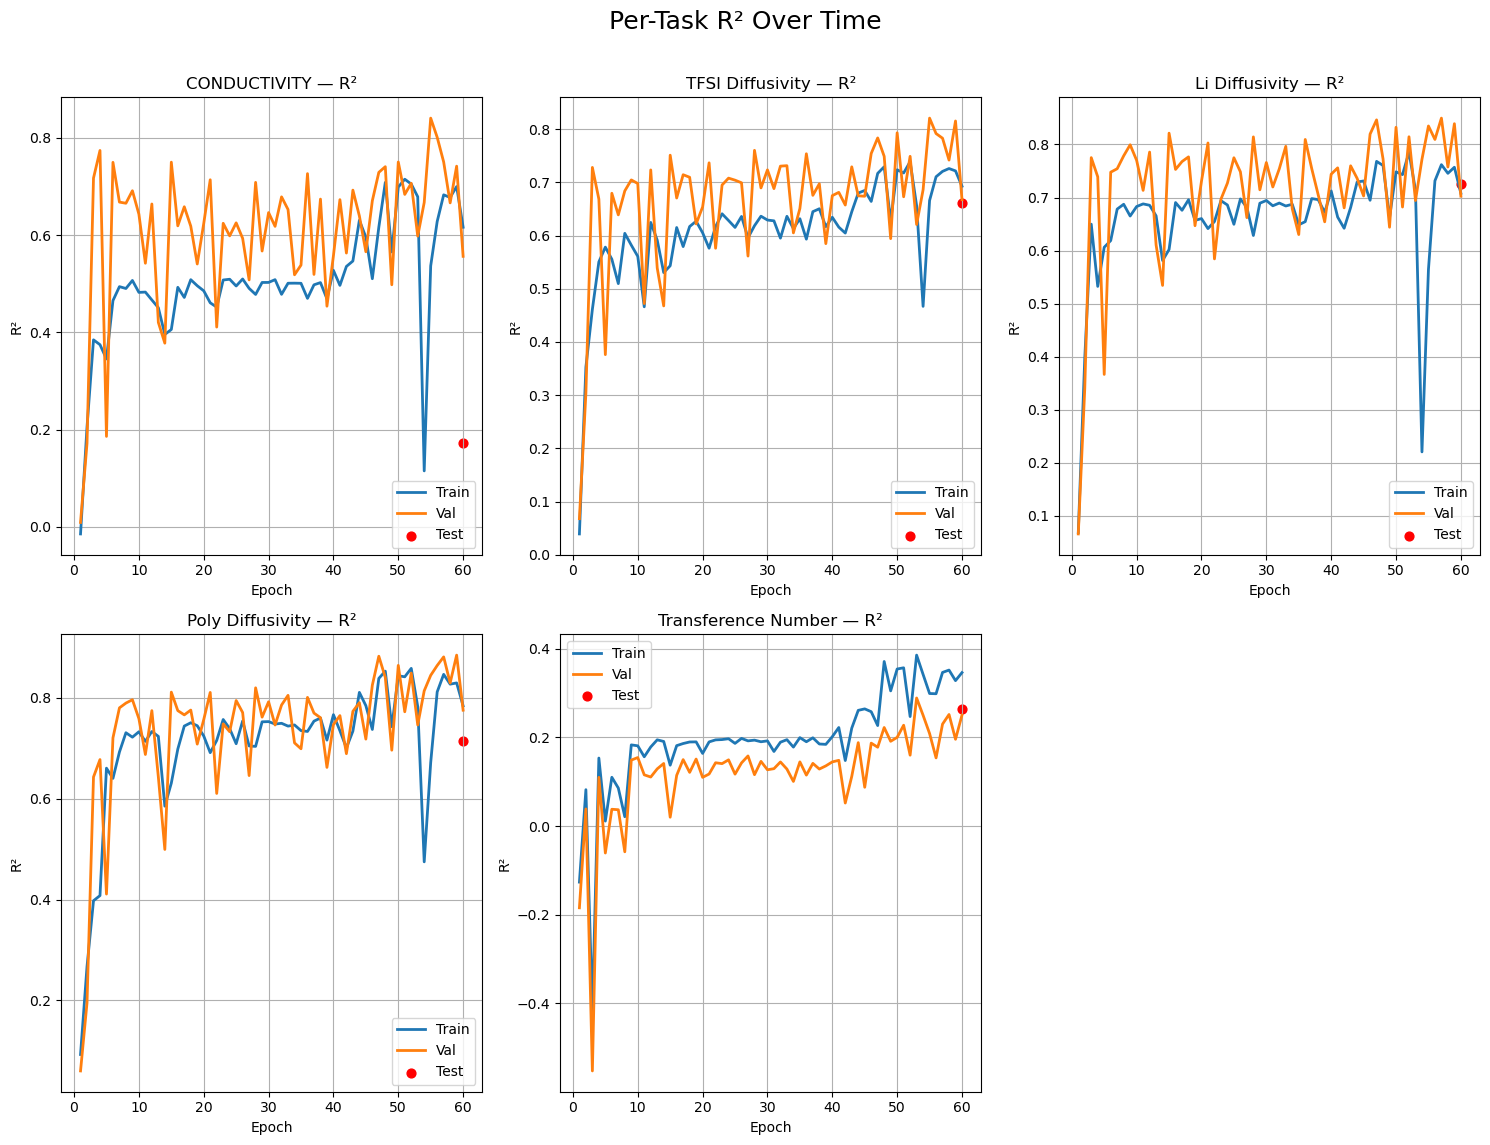

In [ ]:
final_model, final_metrics = model_execution()
print('\n\nDone!')

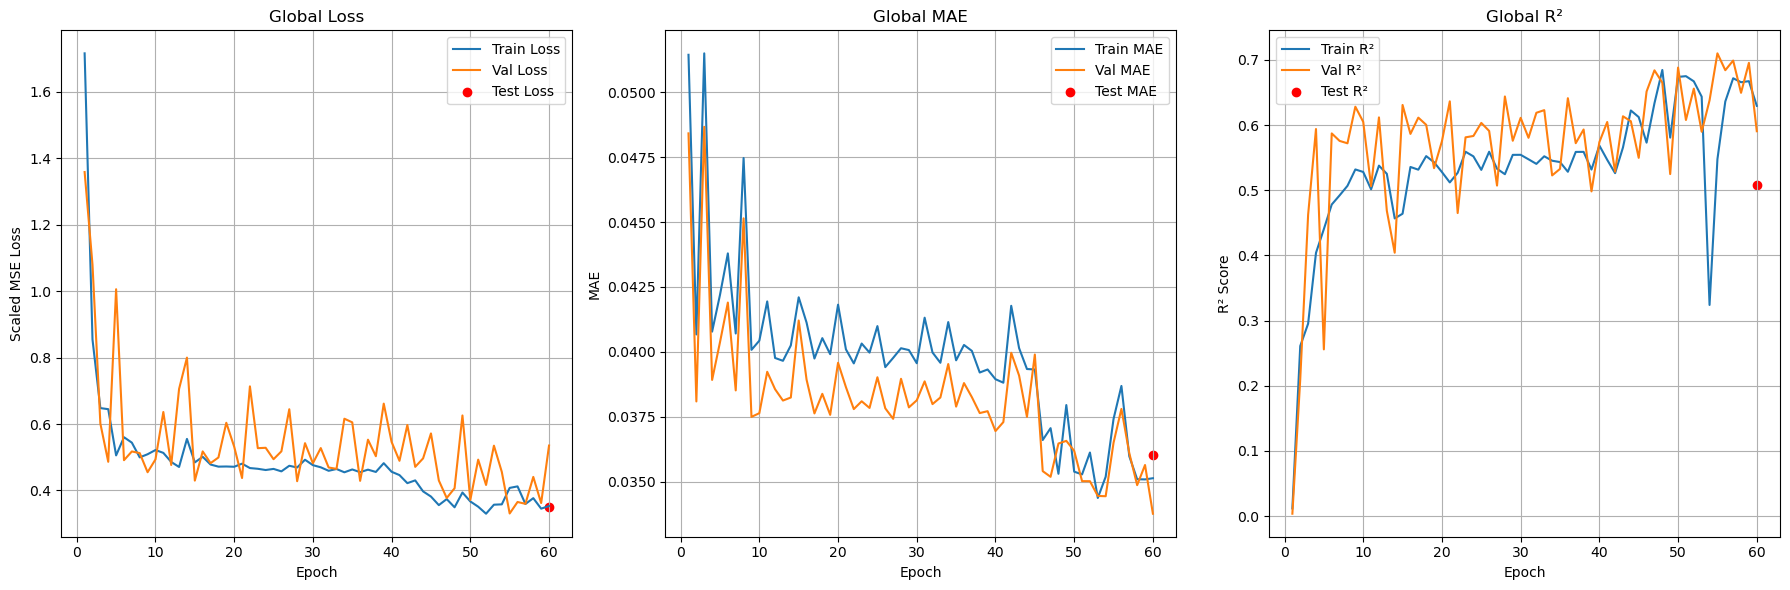

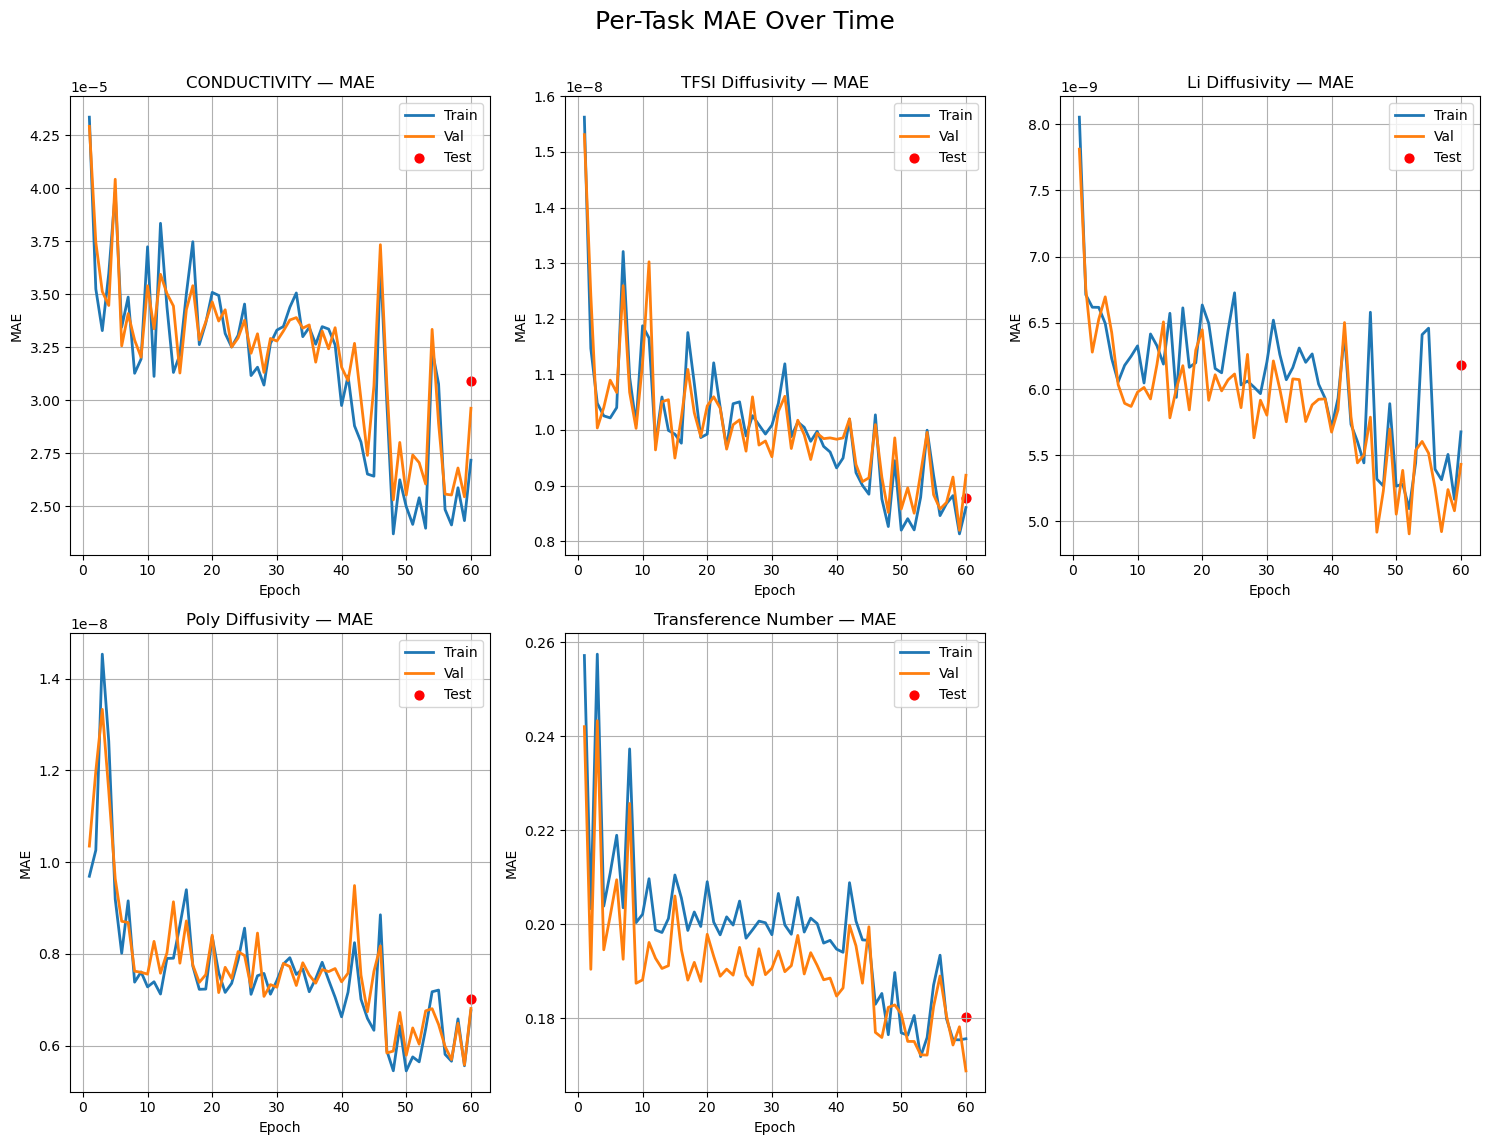

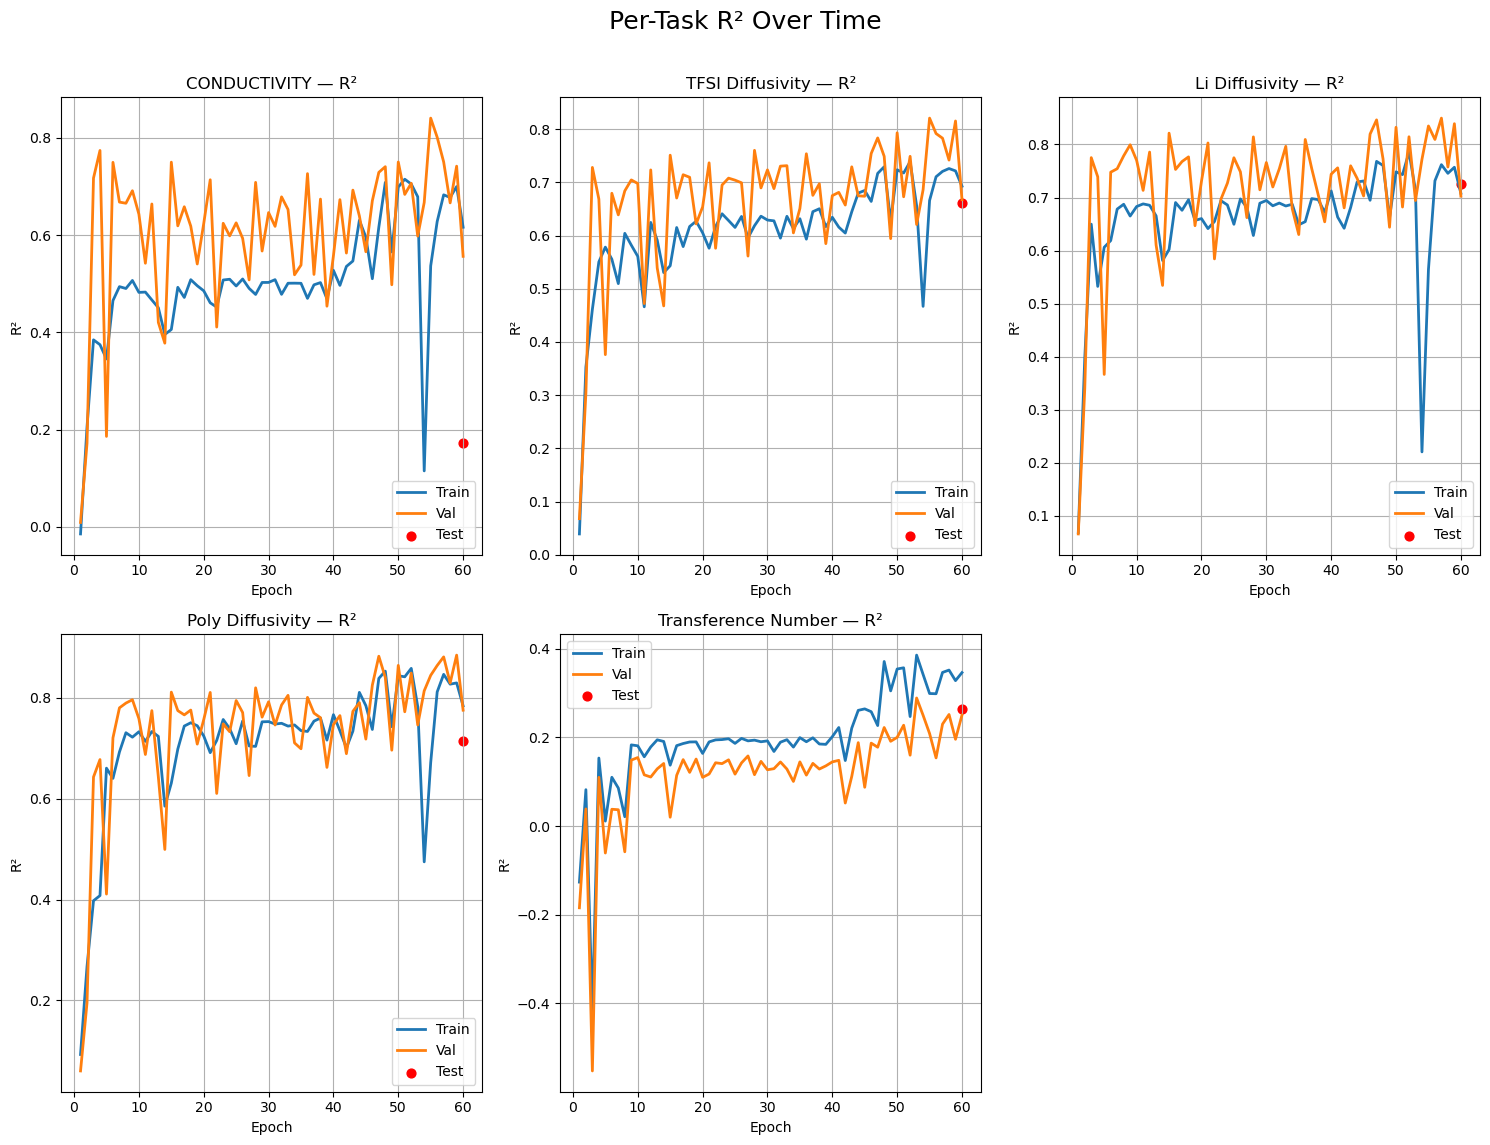

In [18]:
plot_all_metrics(final_metrics, target_cols, num_epochs)

In [ ]:
old_combined = pd.read_csv('./data/combined_featurized_data.csv')
old_featurized = pd.read_csv('./data/featurized_ionic_conductivity_dataset.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6270 entries, 0 to 6269
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   row_index                   6270 non-null   int64  
 1   Molality                    6270 non-null   float64
 2   Monomer Molecular Weight    6270 non-null   float64
 3   Degree of Polymerization    6270 non-null   float64
 4   CONDUCTIVITY                6270 non-null   float64
 5   Mol_smiles_clean            6270 non-null   object 
 6   is_valid                    6270 non-null   bool   
 7   Count_P                     6270 non-null   int64  
 8   Count_Cl                    6270 non-null   int64  
 9   Count_O                     6270 non-null   int64  
 10  Count_Si                    6270 non-null   int64  
 11  Count_C                     6270 non-null   int64  
 12  Count_F                     6270 non-null   int64  
 13  Count_N                     6270 

In [35]:
old_combined.info()
old_featurized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6270 entries, 0 to 6269
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   row_index                   6270 non-null   int64  
 1   Molality                    6270 non-null   float64
 2   Monomer Molecular Weight    6270 non-null   float64
 3   Degree of Polymerization    6270 non-null   float64
 4   CONDUCTIVITY                6270 non-null   float64
 5   Mol_smiles_clean            6270 non-null   object 
 6   is_valid                    6270 non-null   bool   
 7   Count_P                     6270 non-null   int64  
 8   Count_Cl                    6270 non-null   int64  
 9   Count_O                     6270 non-null   int64  
 10  Count_Si                    6270 non-null   int64  
 11  Count_C                     6270 non-null   int64  
 12  Count_F                     6270 non-null   int64  
 13  Count_N                     6270 

In [31]:
unique_cols1 = set()
unique_cols2 = set()
shared_cols = set()

for col1 in old_combined.columns:
    if col1 not in old_featurized.columns:
        unique_cols1.add(col1)
    else:
        shared_cols.add(col1)

for col2 in old_featurized.columns:
    if col2 not in old_combined.columns:
        unique_cols2.add(col2)
    else:
        shared_cols.add(col2)

print(f'Shared columns ({len(shared_cols)}): \n{shared_cols}\n')
print(f'Columns unique to old_combined ({len(unique_cols1)}): \n{unique_cols1}\n')
print(f'Columns unique to old_featurized ({len(unique_cols2)}): \n{unique_cols2}\n')


Shared columns (19): 
{'NumRotatableBonds', 'MolLogP', 'AromaticAtomCount', 'Mol_smiles_clean', 'NumHAcceptors', 'is_valid', 'Degree of Polymerization', 'RingCount', 'SASA_sum', 'Monomer Molecular Weight', 'Topological_diameter_bonds', 'EState_std', 'FractionCSP3', 'EState_sum', 'EState_max', 'TPSA', 'NumHDonors', 'Molality', 'CONDUCTIVITY'}

Columns unique to old_combined (45): 
{'FG_thiol', 'LabuteASA', 'NumAliphaticRings', 'Chi0', 'Heteroatom_count', 'Num_positive_atoms', 'Num_negative_atoms', 'TPSA_ratio', 'MaxCharge', 'Count_P', 'NumAromaticRings', 'row_index', 'Total_formal_charge', 'Poly Diffusivity', 'FG_sulfonyl', 'FG_aromatic_ring', 'MolWt', 'Chi1', 'TFSI Diffusivity', 'MeanCharge', 'FG_amine_secondary', 'Count_N', 'Count_S', 'EState_mean', 'Transference Number', 'HeavyAtomCount', 'MinCharge', 'FG_tertiary_amine', 'Count_Cl', 'MolCharge', 'Longest_chain_atoms_est', 'Li Diffusivity', 'FG_amine_primary', 'Count_O', 'Kappa2', 'FG_phosphate', 'Count_C', 'LogP', 'Kappa1', 'FG_carb